# RAG 최적화

## 점수 출력 Helper

In [1]:
from azure.search.documents import SearchItemPaged

def print_results(results: SearchItemPaged[dict]):
    semantic_answers = results.get_answers()
    if semantic_answers:
        for answer in semantic_answers:
            if answer.highlights:
                print(f"Semantic Answer: {answer.highlights}")
            else:
                print(f"Semantic Answer: {answer.text}")
            print(f"Semantic Answer Score: {answer.score}\n")

    for result in results:
        # print(f"Title: {result['title']}")  
        print(f"Score: {result['@search.score']}")
        if result.get('@search.reranker_score'):
            print(f"Reranker Score: {result['@search.reranker_score']}")
        print(f"Content: {result['main_text']}")  
        # print(f"Category: {result['new_product_name']}\n")

        captions = result["@search.captions"]
        if captions:
            caption = captions[0]
            if caption.highlights:
                print(f"Caption: {caption.highlights}\n")
            else:
                print(f"Caption: {caption.text}\n")
        print("-" * 200)

## 환경 변수

In [12]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizedQuery,
    SearchScoreThreshold,
    VectorSimilarityThreshold,
    QueryType, 
    QueryAnswerType,
    QueryCaptionType,
    QueryDebugMode
)
from azure.search.documents import SearchClient
from dotenv import load_dotenv

import os
load_dotenv(override=True)   

search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
index_name = os.getenv("AZURE_SEARCH_INDEX")
admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
openai_key = os.getenv("AZURE_OPENAI_KEY")
ada002_deployment = os.getenv("AZURE_OPENAI_ADA002_EMBEDDING_DEPLOYMENT")
large3_deployment = os.getenv("AZURE_OPENAI_3_LARGE_EMBEDDING_DEPLOYMENT")
gpt_deployment = os.getenv("AZURE_OPENAI_GPT_DEPLOYMENT")
ai_project_conn_str = os.getenv("AZURE_AI_PROJECT_CONN_STR")

QUERIES_FILE = "queries_low_score2.json"

print(f"search_endpoint: {search_endpoint}")


In [13]:
embed_client = AzureOpenAI(
    azure_deployment=ada002_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_key,
)

embed3_client = AzureOpenAI(
    azure_deployment=large3_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_key,
)

search_client = SearchClient(endpoint=search_endpoint, index_name=index_name, credential=AzureKeyCredential(admin_key))

with open('main_prompt_plain.txt', 'r') as file:
    prompt_template = file.read()


### Vectory only

In [14]:
def search_query(embedding, product_group_code, query_text=None, vector_field="main_text_vector"):
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=50, fields=vector_field, 
                                #    threshold=VectorSimilarityThreshold(value=0.84)
                                   )

    results = search_client.search(
        search_text=query_text,
        vector_queries=[vector_query],
        filter=f"product_group_code eq '{product_group_code}'",
        top=3
    )
    return results

### Vector Search with Semantic Reranker

In [25]:
def search_query(embedding, product_group_code, query_text = None, vector_field="main_text_vector"):
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=50, fields=vector_field,
                                #    threshold=VectorSimilarityThreshold(value=0.84)
                                   )

    results = search_client.search(
        search_text=query_text,
        vector_queries=[vector_query],
        filter=f"product_group_code eq '{product_group_code}'",
        query_type=QueryType.SEMANTIC,
        semantic_configuration_name="my-semantic-config",
        query_language="en",
        query_caption=QueryCaptionType.EXTRACTIVE,
        query_answer=QueryAnswerType.EXTRACTIVE,    
        top=3
    )
    return results

### Hybrid BM25 + Vector Search (with Query Rewrite)

In [ ]:
def search_query(embedding, product_group_code, query_text = None, vector_field="main_text_vector"):
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=50, fields=vector_field, 
                                   threshold=VectorSimilarityThreshold(value=0.78)
                                   )

    results = search_client.search(
        search_text=query_text,
        # search_text=None, # use No-BM25 search
        vector_queries=[vector_query],
        filter=f"product_group_code eq '{product_group_code}'",
        query_type=QueryType.SEMANTIC,
        semantic_configuration_name="my-semantic-config",
        query_language="en",
        query_rewrites="generative|count-5",
        debug=QueryDebugMode.QUERY_REWRITES,
        query_caption=QueryCaptionType.EXTRACTIVE,
        query_answer=QueryAnswerType.EXTRACTIVE,    
        top=3
    )
    return results

### Embedding ada 2

In [15]:
import json

def get_embedding(query):
    return embed_client.embeddings.create(input=[query], model=ada002_deployment).data[0].embedding

documents = []
query_document = []

with open(QUERIES_FILE, 'r') as f:
    queries = json.load(f)

for query in queries:
    # print(query['query'])
    embedding = get_embedding(query['query'])
    product_group_code = query['product_group_code']
    results = search_query(embedding, product_group_code)    
    for res in results:
        documents.append(res['main_text'])
    document_content = "\n".join(documents)
    query_document.append({"query": query['query'], "document_content": document_content})
    # print(document_content)

with open('queries_contexts.json', 'w') as outfile:
    json.dump(query_document, outfile, ensure_ascii=False, indent=4)
    


### Embedding large 3

In [32]:
import json

def get_embedding3(query):
    return embed3_client.embeddings.create(input=[query], model=large3_deployment).data[0].embedding

documents = []
query_document = []

with open(QUERIES_FILE, 'r') as f:
    queries = json.load(f)

for query in queries:
    # print(query['query'])
    embedding = get_embedding3(query['query'])
    product_group_code = query['product_group_code']
    results = search_query(embedding, product_group_code, query_text=query['query'], vector_field="main_text_vector_3")
    for res in results:
        documents.append(res['main_text'])
    document_content = "\n".join(documents)
    query_document.append({"query": query['query'], "document_content": document_content})
    print(document_content)

with open('queries_contexts.json', 'w') as outfile:
    json.dump(query_document, outfile, ensure_ascii=False, indent=4)
    


### RAG Orchestrator

이 셀 이후 모두 실행

In [33]:
def process_llm(query, document_content):
    openai_client = AzureOpenAI(
        azure_deployment=gpt_deployment,
        api_version="2024-10-21",
        azure_endpoint=openai_endpoint,
        api_key=openai_key,
    )

    prompt = prompt_template.replace("{question}", query)
    prompt = prompt.replace("{document}", document_content)
    response = openai_client.chat.completions.create(
        model=gpt_deployment,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    answer = response.choices[0].message.content.strip()
    return answer

with open('queries_contexts.json', 'r') as f:
    queries_document = json.load(f)

query_answers_contexts = []

for query_doc in queries_document:
    query = query_doc['query']
    document_content = query_doc['document_content']
    answer = process_llm(query, document_content) 
    # print(f"Query: {query}\nAnswer: {answer}\n")

    query_answers_contexts.append({
        "query": query,
        "document_content": document_content,
        "answer": answer
    })

with open('queries_answers.jsonl', 'w') as outfile:
    for item in query_answers_contexts:
        json.dump(item, outfile, ensure_ascii=False)
        outfile.write('\n')




## Evaluate by Azure AI Evaluator

질문에 대해 적절한 답변을 평가하는 Relevance Evaluator로만 평가 

In [ ]:
import os
from datetime import datetime
from azure.ai.evaluation import (
    evaluate, 
    FluencyEvaluator, 
    GroundednessEvaluator, 
    RelevanceEvaluator, 
    CoherenceEvaluator,
    SimilarityEvaluator,

)

column_mapping = {
    "query": "${data.query}",
    "context": "${data.document_content}",
    "response": "${data.answer}"
}


model_config = {
    "azure_endpoint": openai_endpoint,
    "api_key": openai_key,
    "azure_deployment": gpt_deployment,
    "api_version": "2024-10-01-preview",
}


fluencyEvaluator = FluencyEvaluator(model_config)
groundednessEvaluator = GroundednessEvaluator(model_config)
relevanceEvaluator = RelevanceEvaluator(model_config)
coherenceEvaluator = CoherenceEvaluator(model_config)
similarityEvaluator = SimilarityEvaluator(model_config)

azure_ai_project = {
    "subscription_id": os.environ.get("AZURE_SUBSCRIPTION_ID"),
    "resource_group_name": os.environ.get("AZURE_RESOURCE_GROUP_NAME"),
    "project_name": os.environ.get("AZURE_PROJECT_NAME"),
}

current_time = datetime.now().strftime("%Y%m%d%H%M%S")
output_file_name = f"evaluation_results_{current_time}.json"

result = evaluate(
    data="queries_answers.jsonl",
    evaluators={
        # "fluency": fluencyEvaluator,
        # "groundedness": groundednessEvaluator,
        "relevance": relevanceEvaluator,
        # "coherence": coherenceEvaluator,
        # "similarity": similarityEvaluator,
    },
    evaluator_config={
        # "fluency": {
        #     "column_mapping": column_mapping
        # },
        # "groundedness": {
        #     "column_mapping": column_mapping
        # },
        "relevance": {
            "column_mapping": column_mapping
        },
        # "coherence": {
        #     "column_mapping": column_mapping
        # },
        # "similarity": {
        #     "column_mapping": column_mapping
        # }
    },
    azure_ai_project=azure_ai_project,
    output_path=output_file_name
)


[2025-02-11 17:24:31 +0900][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-02-11 17:24:31 +0900][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_ctb99yup_20250211_172431_776010, log path: /Users/andy/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_ctb99yup_20250211_172431_776010/logs.txt


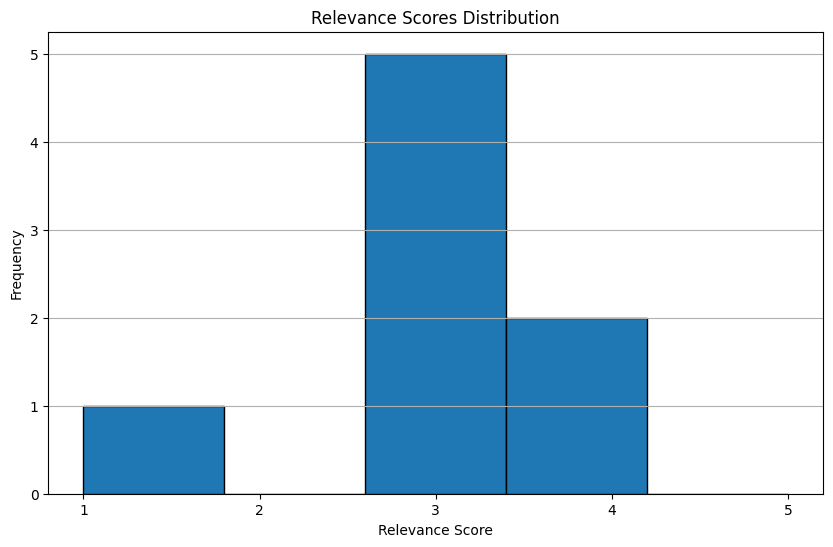

In [35]:
import json

import matplotlib.pyplot as plt

# Read the evaluation results from the JSON file
with open(output_file_name, 'r') as f:
    evaluation_results = json.load(f)

# Extract the relevance scores
relevance_scores = [row['outputs.relevance.relevance'] for row in evaluation_results['rows']]

# Plot the relevance scores
plt.figure(figsize=(10, 6))
plt.hist(relevance_scores, bins=5, range=(1, 5), edgecolor='black')
plt.title('Relevance Scores Distribution')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(axis='y')

# Show the plot
plt.show()

### 3점 이하 Relevance Score 확인

In [ ]:
import sys

low_relevance_queries = [(index, row['inputs.query']) for index, row in enumerate(evaluation_results['rows']) if row['outputs.relevance.relevance'] <= 3]

for index, query in low_relevance_queries:
    print(f"#{index}, Query: {query}")

sys.stdout.flush()
